In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import sys
from functools import partial
sys.path.append('../../')

import jax
import jax.numpy as jnp
from ml_collections import ConfigDict
import matplotlib.pyplot as plt
from matplotlib import colormaps


from sdebridge.sde import FourierGaussianKernelSDE
from sdebridge.diffusion_bridge import DiffusionBridge
from sdebridge.data_processing import butterfly_amasina_pts, butterfly_honrathi_pts
from sdebridge.utils import eval_score

S0 shape:  (120, 2)
ST shape:  (120, 2)
S0_eval shape:  (8, 2)
X0 shape:  (8, 2)
XT shape:  (8, 2)
XT shape (Padded):  (120, 2)


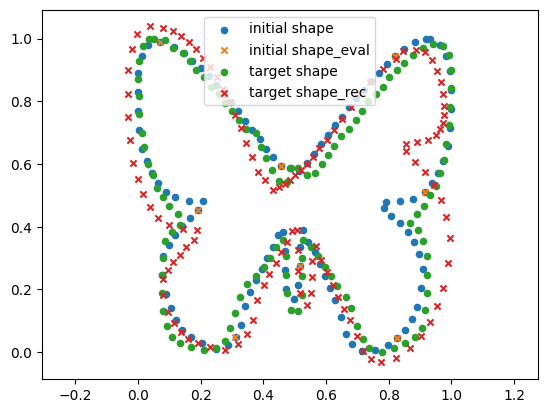

In [4]:
S0 = jnp.roll(jnp.array(butterfly_honrathi_pts())[:, ::219].transpose(), shift=-33, axis=0)
ST = jnp.array(butterfly_amasina_pts())[:, ::200].transpose()
print("S0 shape: ", S0.shape)
print("ST shape: ", ST.shape)

n_bases = 8
n_samples = S0.shape[0]

sde_config = ConfigDict(
    {
        'init_S': S0,
        'n_bases': n_bases,
        'n_grid': 64,
        'grid_range': [-1.5, 1.5],
        'alpha': 1.0,
        'sigma': 0.1,
        'T': 1.0,
        'N': 50,
        'dim': 2
    }
)

sde = FourierGaussianKernelSDE(sde_config)
bridge = DiffusionBridge(sde)
S0_eval = sde.evaluate_S(sde.init_S)
print("S0_eval shape: ", S0_eval.shape)

X0 = jnp.zeros((sde.n_bases, 2), dtype=jnp.complex64)
print("X0 shape: ", X0.shape)
XT_eval = ST - S0
XT = jnp.fft.fft(XT_eval, norm="backward", n=sde.n_samples, axis=0)
XT = jnp.fft.fftshift(XT, axes=0)
XT = XT[(sde.n_samples-sde.n_bases)//2:(sde.n_samples+sde.n_bases)//2, :]
print("XT shape: ", XT.shape)
XT_pad = jnp.pad(XT, ((sde.n_padding, sde.n_padding), (0, 0)))
print("XT shape (Padded): ", XT_pad.shape) 
XT_pad = jnp.fft.ifftshift(XT_pad, axes=0)
XT_rec = jnp.fft.ifft(XT_pad, norm="backward", n=sde.n_samples, axis=0).real
ST_rec = XT_rec + S0

with jax.default_device(jax.devices('cpu')[0]):
    plt.scatter(S0[:, 0], S0[:, 1], s=20, label='initial shape')
    plt.scatter(S0_eval[:, 0].real, S0_eval[:, 1].real, s=20, marker='x', label='initial shape_eval')
    plt.scatter(ST[:, 0], ST[:, 1], s=20, label='target shape')
    plt.scatter(ST_rec[:, 0], ST_rec[:, 1], s=20, marker='x', label='target shape_rec')
    plt.legend()
    plt.axis('equal')
    plt.show()

In [6]:
X0_flatten = jnp.concatenate((X0[:, 0], X0[:, 1]), axis=0)
XT_flatten = jnp.concatenate((XT[:, 0], XT[:, 1]), axis=0)
print("X0_flatten shape: ", X0_flatten.shape)
print("XT_flatten shape: ", XT_flatten.shape)
forward_uncond = bridge.simulate_forward_process(
    initial_val = X0_flatten,
    num_batches = 4
)

# %timeit forward_uncond = bridge.simulate_forward_process(initial_val = X0_flatten, num_batches = 64)

X0_flatten shape:  (16,)
XT_flatten shape:  (16,)


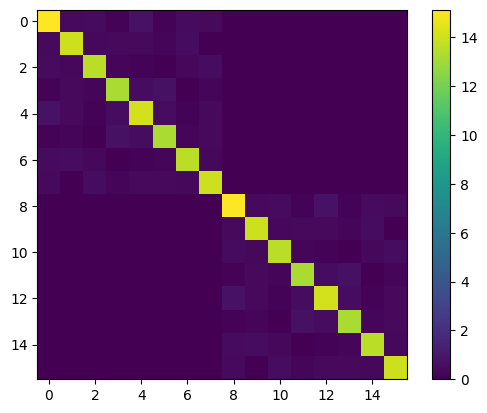

In [7]:
_covariance = sde.covariance(X0_flatten, time=0.0)
plt.imshow(jnp.abs(_covariance), cmap='viridis')
plt.colorbar()

In [8]:
Xs_flatten = forward_uncond["trajectories"]
print("Xs_flatten shape: ", Xs_flatten.shape)
Xs = jnp.stack(jnp.split(Xs_flatten, 2, axis=-1), axis=-1)
print("Xs shape: ", Xs.shape)
Xs_pad = jnp.pad(Xs, pad_width=((0, 0), (0, 0), (sde.n_padding, sde.n_padding), (0, 0)), mode='constant', constant_values=0)
print("Xs shape (padded): ", Xs_pad.shape)
Xs_pad = jnp.fft.ifftshift(Xs_pad, axes=-2)
Xs_rec = jnp.fft.ifft(Xs_pad, norm="backward", n=n_samples, axis=-2)
print("Xs_rec shape: ", Xs_rec.shape)

Ss = S0[None, None, :, :] + Xs_rec.real
print("Ss shape: ", Ss.shape)

Xs_flatten shape:  (4, 50, 16)
Xs shape:  (4, 50, 8, 2)
Xs shape (padded):  (4, 50, 120, 2)
Xs_rec shape:  (4, 50, 120, 2)
Ss shape:  (4, 50, 120, 2)


(-0.07089985050261022,
 1.065887003019452,
 -0.21130046471953393,
 1.1395896546542645)

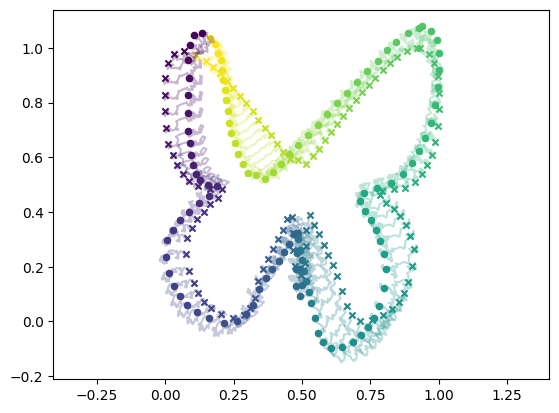

In [9]:
sample_idx = 3
# get the colormap
cmap = colormaps.get_cmap('viridis')
colors = cmap(jnp.linspace(0, 1, sde.n_samples))
for i in range(sde.n_samples):
    plt.scatter(Ss[sample_idx, 0, i, 0], Ss[sample_idx, 0, i, 1], s=20, marker='x', color=colors[i])
    plt.scatter(Ss[sample_idx, -1, i, 0], Ss[sample_idx, -1, i, 1], s=20, marker='o', color=colors[i])
    plt.plot(Ss[sample_idx, :, i, 0], Ss[sample_idx, :, i, 1], color=colors[i], alpha=0.3)
plt.axis('equal')

In [10]:
setup_params = {
    "network": {
        "output_dim": 2*sde.dim*sde.n_bases,
        "time_embedding_dim": 32,
        "init_embedding_dim": 32,
        "act_fn": "silu",
        "encoder_layer_dims": [64, 32, 16, 8],
        "decoder_layer_dims": [8, 16, 32, 64],
        "batchnorm": True,
    },
    "training": {
        "batch_size": 64,
        "num_epochs": 100,
        "num_batches_per_epoch": 200,
        "learning_rate": 1e-3,
        "warmup_steps": 1000,
    }
}

score_p_state = bridge.learn_p_score(
    initial_val=X0_flatten,
    setup_params=setup_params,
)

+------------------------------------------------+-----------+-------+-----------+--------+
| Name                                           | Shape     | Size  | Mean      | Std    |
+------------------------------------------------+-----------+-------+-----------+--------+
| Dense_0/Dense_0/bias                           | (8,)      | 8     | 0.0       | 0.0    |
| Dense_0/Dense_0/kernel                         | (8, 8)    | 64    | -0.0309   | 0.339  |
| Dense_1/Dense_0/bias                           | (32,)     | 32    | 0.0       | 0.0    |
| Dense_1/Dense_0/kernel                         | (64, 32)  | 2,048 | 0.0016    | 0.145  |
| Downsample_0/BatchNorm_0/bias                  | (64,)     | 64    | 0.0       | 0.0    |
| Downsample_0/BatchNorm_0/scale                 | (64,)     | 64    | 1.0       | 0.0    |
| Downsample_0/Dense_0/Dense_0/bias              | (32,)     | 32    | 0.0       | 0.0    |
| Downsample_0/Dense_0/Dense_0/kernel            | (32, 32)  | 1,024 | 0.00257  

Training: 100%|██████████| 100/100 [10:46<00:00,  6.47s/epoch, Epoch=100, loss=7.1627]


In [20]:
@jax.jit
def score_p(val, time):
    score_output = score_p_state.apply_fn(
        {"params": score_p_state.params, "batch_stats": score_p_state.batch_stats},
        x_complex=val,
        t=time,
        train=False
    )
    score_real, score_imag = jnp.split(score_output, 2, axis=-1)
    score = score_real + 1j * score_imag
    return score

backward_brownian_bridge = bridge.simulate_backward_bridge(
    initial_val=X0_flatten,
    terminal_val=XT_flatten,
    score_p=score_p,
    num_batches=8,
)

# %timeit backward_brownian_bridge = bridge.simulate_backward_bridge(initial_val=X0_flatten, terminal_val=XT_flatten, score_p=score_p, num_batches=64)

In [21]:
Xs_flatten = backward_brownian_bridge["trajectories"]
print("Xs_flatten shape: ", Xs_flatten.shape)
Xs = jnp.stack(jnp.split(Xs_flatten, 2, axis=-1), axis=-1)
print("Xs shape: ", Xs.shape)
Xs_pad = jnp.pad(Xs, pad_width=((0, 0), (0, 0), (sde.n_padding, sde.n_padding), (0, 0)), mode='constant', constant_values=0)
print("Xs shape (padded): ", Xs_pad.shape)
Xs_pad = jnp.fft.ifftshift(Xs_pad, axes=-2)
Xs_rec = jnp.fft.ifft(Xs_pad, norm="backward", n=n_samples, axis=-2)
print("Xs_rec shape: ", Xs_rec.shape)

Ss = S0[None, None, :, :] + Xs_rec.real
print("Ss shape: ", Ss.shape)

Xs_flatten shape:  (8, 50, 16)
Xs shape:  (8, 50, 8, 2)
Xs shape (padded):  (8, 50, 120, 2)
Xs_rec shape:  (8, 50, 120, 2)
Ss shape:  (8, 50, 120, 2)


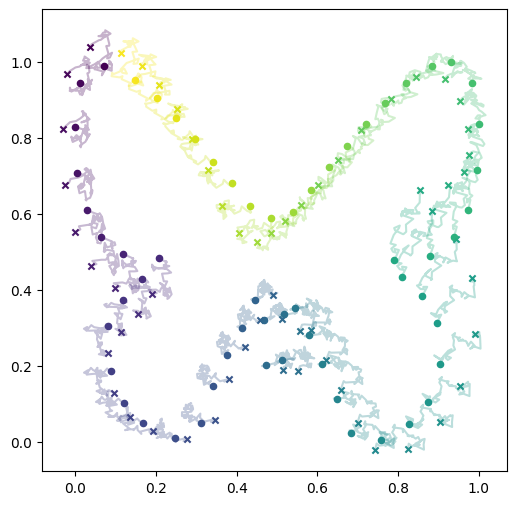

In [22]:
sample_idx = 1
# get the colormap
cmap = colormaps.get_cmap('viridis')
colors = cmap(jnp.linspace(0, 1, sde.n_samples))
plt.figure(figsize=(6, 6))
with jax.default_device(jax.devices('cpu')[0]):
    for i in jnp.arange(sde.n_samples)[::2]:
        plt.scatter(Ss[sample_idx, 0, i, 0], Ss[sample_idx, 0, i, 1], s=20, marker='x', color=colors[i])
        plt.scatter(Ss[sample_idx, -1, i, 0], Ss[sample_idx, -1, i, 1], s=20, marker='o', color=colors[i])
        plt.plot(Ss[sample_idx, :, i, 0], Ss[sample_idx, :, i, 1], color=colors[i], alpha=0.3)

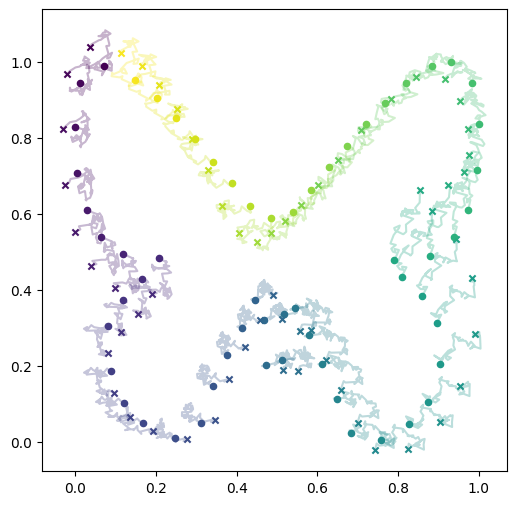

In [19]:
sample_idx = 1
# get the colormap
cmap = colormaps.get_cmap('viridis')
colors = cmap(jnp.linspace(0, 1, sde.n_samples))
plt.figure(figsize=(6, 6))
with jax.default_device(jax.devices('cpu')[0]):
    for i in jnp.arange(sde.n_samples)[::2]:
        plt.scatter(Ss[sample_idx, 0, i, 0], Ss[sample_idx, 0, i, 1], s=20, marker='x', color=colors[i])
        plt.scatter(Ss[sample_idx, -1, i, 0], Ss[sample_idx, -1, i, 1], s=20, marker='o', color=colors[i])
        plt.plot(Ss[sample_idx, :, i, 0], Ss[sample_idx, :, i, 1], color=colors[i], alpha=0.3)

In [51]:
setup_params = {
    "network": {
        "output_dim": 2*sde.dim*sde.n_bases,
        "time_embedding_dim": 32,
        "init_embedding_dim": 32,
        "act_fn": "silu",
        "encoder_layer_dims": [64, 32, 16, 8],
        "decoder_layer_dims": [8, 16, 32, 64],
        "batchnorm": True,
    },
    "training": {
        "batch_size": 64,
        "num_epochs": 100,
        "num_batches_per_epoch": 200,
        "learning_rate": 1e-3,
        "warmup_steps": 1000,
    }
}

score_p_star_state = bridge.learn_p_star_score(
    initial_val=X0_flatten,
    terminal_val=XT_flatten,
    score_p=score_p,
    setup_params=setup_params,
)

+------------------------------------------------+-----------+-------+-----------+--------+
| Name                                           | Shape     | Size  | Mean      | Std    |
+------------------------------------------------+-----------+-------+-----------+--------+
| Dense_0/Dense_0/bias                           | (8,)      | 8     | 0.0       | 0.0    |
| Dense_0/Dense_0/kernel                         | (8, 8)    | 64    | -0.0309   | 0.339  |
| Dense_1/Dense_0/bias                           | (32,)     | 32    | 0.0       | 0.0    |
| Dense_1/Dense_0/kernel                         | (64, 32)  | 2,048 | 0.0016    | 0.145  |
| Downsample_0/BatchNorm_0/bias                  | (64,)     | 64    | 0.0       | 0.0    |
| Downsample_0/BatchNorm_0/scale                 | (64,)     | 64    | 1.0       | 0.0    |
| Downsample_0/Dense_0/Dense_0/bias              | (32,)     | 32    | 0.0       | 0.0    |
| Downsample_0/Dense_0/Dense_0/kernel            | (32, 32)  | 1,024 | 0.00257  

Training: 100%|██████████| 100/100 [11:11<00:00,  6.72s/epoch, Epoch=100, loss=6.5583]


In [52]:
@jax.jit
def score_p_star(val, time):
    score_output = score_p_star_state.apply_fn(
        {"params": score_p_star_state.params, "batch_stats": score_p_star_state.batch_stats},
        x_complex=val,
        t=time,
        train=False
    )
    score_real, score_imag = jnp.split(score_output, 2, axis=-1)
    score = score_real + 1j * score_imag
    return score

def score_h(val, time):
    return score_p_star(val, time) - score_p(val, time)

forward_brownian_bridge = bridge.simulate_forward_bridge(
    initial_val=X0_flatten,
    terminal_val=XT_flatten,
    score_h=score_h,
    num_batches=8,
)

In [53]:
Xs_flatten = forward_brownian_bridge["trajectories"]
print("Xs_flatten shape: ", Xs_flatten.shape)
Xs = jnp.stack(jnp.split(Xs_flatten, 2, axis=-1), axis=-1)
print("Xs shape: ", Xs.shape)
Xs_pad = jnp.pad(Xs, pad_width=((0, 0), (0, 0), (sde.n_padding, sde.n_padding), (0, 0)), mode='constant', constant_values=0)
print("Xs shape (padded): ", Xs_pad.shape)
Xs_pad = jnp.fft.ifftshift(Xs_pad, axes=-2)
Xs_rec = jnp.fft.ifft(Xs_pad, norm="backward", n=n_samples, axis=-2)
print("Xs_rec shape: ", Xs_rec.shape)

Ss = S0[None, None, :, :] + Xs_rec.real
print("Ss shape: ", Ss.shape)

Xs_flatten shape:  (8, 50, 16)
Xs shape:  (8, 50, 8, 2)
Xs shape (padded):  (8, 50, 120, 2)
Xs_rec shape:  (8, 50, 120, 2)
Ss shape:  (8, 50, 120, 2)


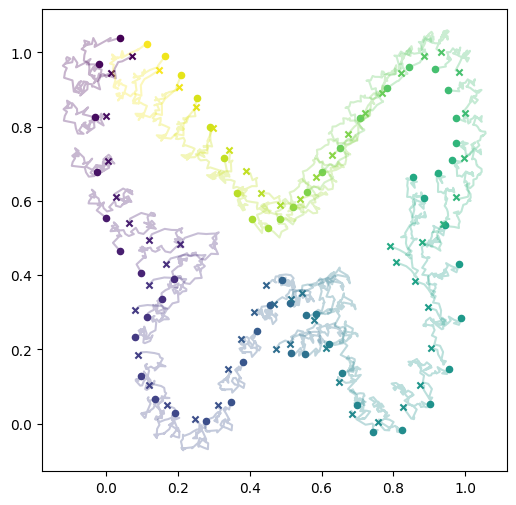

In [61]:
sample_idx = 5
# get the colormap
cmap = colormaps.get_cmap('viridis')
colors = cmap(jnp.linspace(0, 1, sde.n_samples))
plt.figure(figsize=(6, 6))
with jax.default_device(jax.devices('cpu')[0]):
    for i in jnp.arange(sde.n_samples)[::2]:
        plt.scatter(Ss[sample_idx, 0, i, 0], Ss[sample_idx, 0, i, 1], s=20, marker='x', color=colors[i])
        plt.scatter(Ss[sample_idx, -1, i, 0], Ss[sample_idx, -1, i, 1], s=20, marker='o', color=colors[i])
        plt.plot(Ss[sample_idx, :, i, 0], Ss[sample_idx, :, i, 1], color=colors[i], alpha=0.3)

In [58]:
Ss[sample_idx, -2, :, 1]

Array([ 1.0048101e+00,  9.8292726e-01,  9.3825662e-01,  8.7404740e-01,
        8.0530357e-01,  7.3762882e-01,  6.7107433e-01,  6.0563844e-01,
        5.6297570e-01,  5.2129656e-01,  4.8680517e-01,  4.5799634e-01,
        4.3940216e-01,  4.2786667e-01,  4.2766479e-01,  3.9693907e-01,
        3.7298039e-01,  3.4585837e-01,  3.1886253e-01,  2.8652343e-01,
        2.5246680e-01,  1.9341937e-01,  1.3475126e-01,  9.3050227e-02,
        5.7430893e-02,  2.8536417e-02,  1.0561872e-02, -6.6114534e-03,
       -1.7478283e-02, -9.0872869e-05,  3.4486987e-02,  7.9541579e-02,
        1.4782061e-01,  2.0148225e-01,  2.4633262e-01,  2.8925213e-01,
        3.3271158e-01,  3.7478459e-01,  4.1877589e-01,  4.3175131e-01,
        3.7422106e-01,  3.1498709e-01,  2.5395569e-01,  2.1967325e-01,
        2.5999120e-01,  3.1404677e-01,  3.6665764e-01,  4.1260380e-01,
        3.6486167e-01,  3.2162651e-01,  2.7316698e-01,  2.2625986e-01,
        1.7944723e-01,  1.3400668e-01,  7.3877335e-02,  1.5916023e-02,
      